In [1]:
# Import the required libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn.utils.prune as prune
from torch.nn.utils import weight_norm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from captum.attr import LayerGradCam, visualization as viz
import numpy as np
import cv2
import torch.nn.functional as F

In [2]:
# Define the image transformations and load the MNIST dataset

# Image transformations for input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the architecture of the LeNet-5 model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, bias = False)
        self.fc1 = nn.Linear(64 * 5 * 5, 256, bias = False)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

model = Net()


# Define the optimizer, criterion, and move the model to the CPU device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cpu")
model.to(device)

# Train the model for a certain number of epochs:

epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
# Iterate over training data and perform forward and backward pass
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
# Prints average loss for each epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{epochs}, loss: {epoch_loss:.4f}")

# Evaluate the accuracy of the model on the test data   
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nAccuracy of the model : %d %%' % (100 * correct / total))

# # Check if the model is pruned
# is_pruned = prune.is_pruned(model)
# print("\nIs Pruned:", is_pruned)


Epoch 1/5, loss: 1.5386

Epoch 2/5, loss: 1.4882

Epoch 3/5, loss: 1.4816

Epoch 4/5, loss: 1.4787

Epoch 5/5, loss: 1.4762

Accuracy of the model : 98 %


Predicted Label: 6


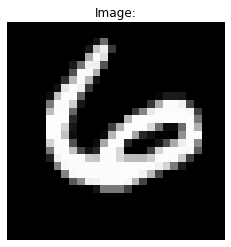

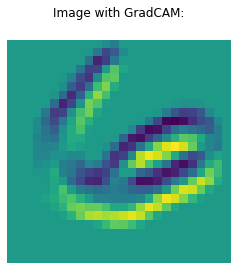

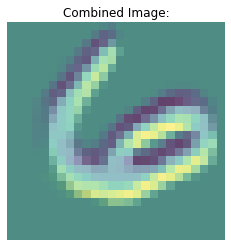

In [3]:
# Set the model to evaluation mode and choose a random image from the test dataset to display
model.eval()

with torch.no_grad():
    test_index = random.randint(0, len(test_dataset)-1)
    test_image, test_label = test_dataset[test_index]
    test_output = model(test_image.unsqueeze(0))
    _, predicted = torch.max(test_output.data, 1)
    print('Predicted Label:', predicted.item())
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title("Image:")
    plt.axis('off')
    plt.show()

# Apply GradCAM visualization to the chosen image
layers = list(model.modules())
image, label = test_image.unsqueeze(0), torch.tensor([predicted.item()])
algorithm = LayerGradCam(model, layer=layers[1])
feature_imp_img = algorithm.attribute(image, target=label)
# print(feature_imp_img.shape)
_, _, h, w = feature_imp_img.shape

# Display the GradCAM heat map
orig_image = np.transpose(test_image.numpy(), (1,2,0))
plt.matshow(feature_imp_img.detach().numpy().reshape(h,w,1), interpolation ='none')
plt.title("Image with GradCAM:")
plt.axis('off')
plt.show()   

# Load and display the first image
image1 = test_image.squeeze()
plt.imshow(image1, alpha=0.5, cmap='gray')
plt.axis('off')

# Load and display the second image with transparency
image2 = feature_imp_img.detach().numpy().reshape(h, w, 1)
plt.imshow(image2, alpha=0.5, interpolation='none')
plt.axis('off')
plt.title("Combined Image:")
# Show the combined image
plt.show()

# Before Pruning

In [4]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=1600, out_features=256, bias=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [5]:
model.conv2.weight

Parameter containing:
tensor([[[[-1.2161e-01, -9.5599e-02, -1.0634e-01],
          [-2.1376e-01, -6.2543e-02, -1.1852e-01],
          [-1.4549e-01, -1.1080e-01, -7.1998e-02]],

         [[ 1.2266e-01, -5.7364e-02,  1.6230e-01],
          [ 3.3845e-02, -4.0630e-02,  4.0689e-01],
          [-2.5490e-02, -7.7232e-02,  2.3847e-01]],

         [[-8.1182e-02, -1.6486e-01, -1.9646e-01],
          [-1.8828e-01, -1.6621e-01, -2.6314e-02],
          [-1.3480e-01, -2.6447e-01, -1.2439e-01]],

         ...,

         [[ 3.9299e-02, -1.2652e-02, -2.6270e-02],
          [ 1.0291e-01, -1.2956e-01,  1.9468e-01],
          [ 1.4042e-01, -1.9362e-01,  1.0670e-01]],

         [[-7.3863e-02, -1.0974e-01,  3.1391e-02],
          [ 3.3861e-02, -3.7610e-02,  2.4318e-01],
          [ 5.6849e-02,  8.0029e-03,  4.7032e-02]],

         [[ 1.4335e-01,  1.9831e-01,  1.8049e-01],
          [ 2.3784e-01,  1.7904e-01,  1.4817e-01],
          [ 1.4609e-01,  1.6619e-01,  7.4922e-02]]],


        [[[-2.2966e-02,  2.5299

In [6]:
model.fc1.weight

Parameter containing:
tensor([[-0.0283, -0.0852, -0.0076,  ...,  0.0660,  0.0923,  0.0937],
        [ 0.0218, -0.0359, -0.1097,  ..., -0.0005, -0.0636,  0.0168],
        [-0.1104,  0.0134, -0.0373,  ..., -0.0326,  0.0565,  0.0704],
        ...,
        [ 0.0203,  0.0265,  0.0399,  ..., -0.0551, -0.0077,  0.0095],
        [-0.0470,  0.0175,  0.1524,  ...,  0.0543, -0.0169, -0.0671],
        [ 0.0644, -0.0133, -0.0491,  ..., -0.0012,  0.0234, -0.0228]],
       requires_grad=True)

In [7]:
# model.conv2.bias

In [8]:
# model.fc1.bias

# Structured pruning

In [9]:
# Specify the layers to prune
layers_to_prune = [model.conv2, model.fc1]

# Prune each layer individually
for layer in layers_to_prune:
    prune.ln_structured(module=layer, name='weight', amount=0.5, n=1, dim=1) # 0=row & 1=column

# Remove zeros from the pruned weights
for layer in layers_to_prune:
    mask = getattr(layer, "weight_mask", None)
    if mask is not None:
        layer.weight.data *= mask  # Set zero weights to zero

# Reinitialize the optimizer and criterion, and set the model to training mode
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

model.train()

# Fine-tune the pruned model for a certain number of epochs
epochs = 3
for epoch in range(epochs):
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Remove zeros from the pruned weights
for layer in layers_to_prune:
    mask = getattr(layer, "weight_mask", None)
    if mask is not None:
        layer.weight.data *= mask  # Set zero weights to zero

correct = 0
total = 0

model.eval()
with torch.no_grad():
    test_image = test_image.unsqueeze(0)
    output = model(test_image)
    _, predicted = torch.max(output, 1)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nAccuracy of the pruned model: {accuracy:.2f}%")

# Check if the model is pruned after the fine-tuning
is_pruned = prune.is_pruned(model)
print("\nIs Pruned:", is_pruned)



Epoch 1/3, Loss: 1.4817

Epoch 2/3, Loss: 1.4723

Epoch 3/3, Loss: 1.4708

Accuracy of the pruned model: 98.73%

Is Pruned: True


# After Pruning

In [10]:
model.conv2.weight

tensor([[[[-0.1044, -0.0688, -0.0832],
          [-0.2145, -0.0420, -0.0835],
          [-0.1400, -0.0921, -0.0617]],

         [[ 0.1956,  0.0693,  0.2892],
          [ 0.1194,  0.1104,  0.5149],
          [ 0.0798,  0.0619,  0.3241]],

         [[-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000]],

         ...,

         [[-0.0017, -0.0453, -0.0663],
          [ 0.0511, -0.1748,  0.1236],
          [ 0.0952, -0.2043,  0.0950]],

         [[-0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[-0.0059,  0.1182, -0.0259],
          [-0.0624, -0.0126, -0.1365],
          [-0.0082, -0.1165,  0.0141]],

         [[-0.0790,  0.2747,  0.1378],
          [ 0.0158,  0.2163,  0.0719],
          [ 0.2201,  0.0623, -0.1575]],

         [[-0.0000, -0.0000,  0

In [11]:
model.fc1.weight

tensor([[-0.0000, -0.0000, -0.0735,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.1432,  ..., -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.1159,  ..., -0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0490,  ..., -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000,  0.2030,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0767,  ..., -0.0000,  0.0000, -0.0000]])

In [12]:
# model.conv2.bias

In [13]:
# model.fc1.bias

In [14]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=1600, out_features=256, bias=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

# Removing Channels of the pruned layers

In [15]:
# Remove zero channels from conv2
weights = model.conv2.weight.data
mask = torch.sum(weights, dim=(1, 2, 3)) != 0
pruned_weights = weights[mask]

# Reduce the number of channels
pruned_channels = pruned_weights.size(0) // 2
pruned_weights = pruned_weights[:pruned_channels]

# Update conv2 with the pruned weights and reduced number of channels
model.conv2 = nn.Conv2d(pruned_weights.size(1), pruned_weights.size(0), kernel_size=4)
#model.conv2.weight = nn.Parameter(pruned_weights)

In [16]:
# Remove zero channels from fc1
weights = model.fc1.weight.data
mask = torch.sum(weights, dim=0) != 0
pruned_weights = weights[:, mask]

# Update fc1 with the pruned weights
model.fc1 = nn.Linear(pruned_weights.size(1), pruned_weights.size(0), bias=True)
model.fc1.weight = nn.Parameter(pruned_weights)

In [17]:
model.conv2.weight

Parameter containing:
tensor([[[[-0.0059, -0.0297,  0.0326,  0.0415],
          [ 0.0065, -0.0292,  0.0112, -0.0194],
          [-0.0157,  0.0399, -0.0185, -0.0394],
          [ 0.0320, -0.0420,  0.0381, -0.0159]],

         [[ 0.0231, -0.0084,  0.0425, -0.0257],
          [-0.0397, -0.0308,  0.0173, -0.0028],
          [ 0.0344,  0.0316,  0.0067, -0.0092],
          [-0.0261,  0.0027, -0.0142,  0.0070]],

         [[-0.0186,  0.0203,  0.0252,  0.0407],
          [ 0.0334,  0.0179, -0.0177, -0.0197],
          [ 0.0354, -0.0257, -0.0070, -0.0208],
          [ 0.0438, -0.0312,  0.0108,  0.0287]],

         ...,

         [[ 0.0085, -0.0107,  0.0275, -0.0003],
          [-0.0216,  0.0291, -0.0358, -0.0138],
          [-0.0045, -0.0046,  0.0301,  0.0404],
          [ 0.0371, -0.0082, -0.0191, -0.0184]],

         [[-0.0404, -0.0277, -0.0184,  0.0318],
          [ 0.0408,  0.0062,  0.0228,  0.0356],
          [ 0.0348, -0.0047,  0.0008, -0.0300],
          [ 0.0395,  0.0114, -0.0039,  0.04

In [18]:
model.fc1.weight

Parameter containing:
tensor([[-0.0735, -0.0025, -0.0673,  ...,  0.1248,  0.1575,  0.1843],
        [-0.1432, -0.1670, -0.0710,  ..., -0.0078, -0.0896, -0.0753],
        [-0.1159, -0.0165, -0.0363,  ...,  0.0479,  0.1107,  0.0342],
        ...,
        [ 0.0490,  0.1176, -0.0670,  ..., -0.1090,  0.0336, -0.0501],
        [ 0.2030,  0.1651,  0.0245,  ..., -0.0048,  0.0383, -0.0161],
        [-0.0767, -0.0021,  0.0263,  ..., -0.0792,  0.0371, -0.0467]],
       requires_grad=True)

In [19]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [21]:
def forward(self, x):
    x = self.pool(torch.tanh(self.model.conv1(x).size))
    x = self.pool(torch.tanh(self.model.conv2(x).size))
    num_remaining_channels = x.size(1)
    x = x.view(-1, num_remaining_channels * 5 * 5)  # Update the view operation
    x = torch.tanh(self.model.fc1(x))
    x = torch.softmax(self.model.fc2(x), dim=1)
    
model = Net()

In [29]:
# model

In [23]:
def find_argmax(image):
    # Threshold the image
    threshold = 0.5  # Adjust the threshold as needed
    binary_image = (image > threshold).float()

    # Find the argmax
    argmax = torch.argmax(binary_image.view(-1))
    return argmax.item()

def plot_bbox(image, bbox, color='red', lw=2):
    ymin, xmin, ymax, xmax = bbox
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=lw))

Predicted Label: 4


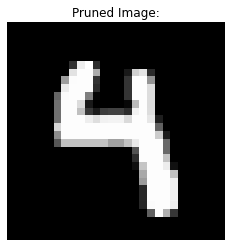

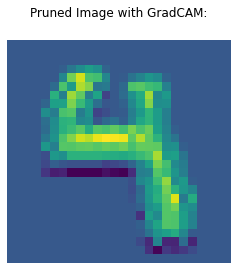

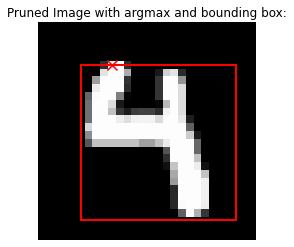

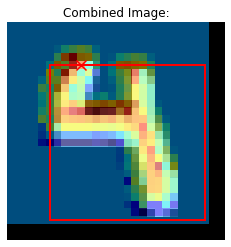

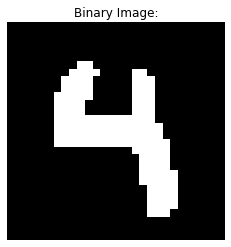

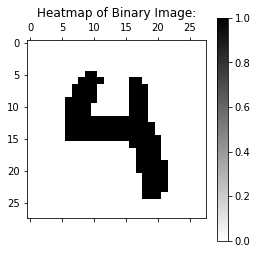

In [28]:
with torch.no_grad():
    test_index = random.randint(0, len(test_dataset)-1)
    test_image, test_label = test_dataset[test_index]
    test_output = model(test_image.unsqueeze(0))
    _, predicted = torch.max(test_output.data, 1)
    print('Predicted Label:', predicted.item())
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title("Pruned Image:")
    plt.axis('off')
    plt.show()
    
    # Applys GradCAM visualization to the same image
    layers = list(model.modules())
    image, label = test_image.unsqueeze(0), torch.tensor([predicted.item()])
    algorithm = LayerGradCam(model, layer=layers[1])
    feature_imp_img = algorithm.attribute(image, target=label)
    _, _, h, w = feature_imp_img.shape

    # Computes bounding box coordinates based on the GradCAM heatmap
    heatmap_np = feature_imp_img.detach().numpy().reshape(h, w)
    threshold = 0.5  # Set a threshold to decide the bounding box
    nonzero_indices = np.nonzero(heatmap_np > threshold)
    
    if nonzero_indices[0].size > 0 and nonzero_indices[1].size > 0:
        ymin = np.min(nonzero_indices[0])
        ymax = np.max(nonzero_indices[0])
        xmin = np.min(nonzero_indices[1])
        xmax = np.max(nonzero_indices[1])
    else:
        ymin, ymax, xmin, xmax = 5, 25, 25, 5

    # Find the argmax for the "white" part
    white_argmax = find_argmax(test_image.squeeze())

    # Displays the GradCAM heat map
    orig_image = test_image.squeeze().numpy()
    plt.matshow(feature_imp_img.detach().numpy().reshape(h, w), interpolation='none')
    plt.title("Pruned Image with GradCAM:")
    plt.axis('off')
    plt.show()

    # Displays the original image with the argmax point and bounding box
    plt.imshow(orig_image, cmap='gray')
    plt.scatter(white_argmax % 28, white_argmax // 28, marker='x', color='red', s=100)
    plot_bbox(orig_image, (ymin, xmin, ymax, xmax), color='red', lw=2)
    plt.title("Pruned Image with argmax and bounding box:")
    plt.axis('off')
    plt.show()

    # Displays the combined image with transparency and bounding box
    plt.imshow(orig_image, cmap='gray')
    plt.imshow(feature_imp_img.detach().numpy().reshape(h, w), cmap='jet', alpha=0.5, interpolation='none')
    plt.scatter(white_argmax % 28, white_argmax // 28, marker='x', color='red', s=100)
    plot_bbox(orig_image, (ymin, xmin, ymax, xmax), color='red', lw=2)
    plt.title("Combined Image:")
    plt.axis('off')
    plt.show()

    # Displays the binary image and its heatmap of 0's and 1's
    binary_image = (orig_image > threshold).astype(int)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binary Image:")
    plt.axis('off')
    plt.show()

    # Creates a heat map of 0's and 1's for the binary image
    plt.matshow(binary_image, cmap='binary', interpolation='none')
    plt.title("Heatmap of Binary Image:")
    plt.colorbar()
    plt.show()
